# CORE API test

主要参考资料： https://github.com/oacore/apiv3-webinar/tree/main

In [1]:
import pandas
from matplotlib import rcParams
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os
from operator import itemgetter

rcParams['figure.figsize'] = 11.7,8.27

def pretty_json(json_object):
    print(json.dumps(json_object, indent=2))

## 基础配置

设置 api key 和 api 请求地址

如果没有 api key，可以在 https://core.ac.uk/services/api/ 注册

- tips: api key 会在注册后发送到邮箱，通常几秒钟就能收到


In [3]:
api_key = "selUJkoS5IhEf89aOwNyBd2gG7zMq0cR"
# with open ("apikey.txt", "r") as apikey_file:
#     api_key=apikey_file.readlines()[0].strip()
api_endpoint = "https://api.core.ac.uk/v3/"

### 定义请求函数

In [34]:
def get_entity(url_fragment):
    headers={"Authorization":"Bearer "+api_key}
    response = requests.get(api_endpoint + url_fragment, headers=headers)
    if response.status_code == 200:
        return response.json(), response.elapsed.total_seconds()
    else:
        print(f"Error code {response.status_code}, {response.content}")

### 测试 api 是否能访问

In [4]:
# 通过 data providers endpoint 获取所有的 id 为 1 de data provider 的信息
data_provider, elapsed = get_entity("data-providers/1")
pretty_json(data_provider)

{
  "id": 1,
  "openDoarId": 1767,
  "name": "Aberdeen University Research Archive",
  "email": "aura.deposit@abdn.ac.uk",
  "uri": null,
  "oaiPmhUrl": "https://aura.abdn.ac.uk/dspace-oai/request",
  "homepageUrl": "http://aura.abdn.ac.uk",
  "source": null,
  "software": "dspace",
  "metadataFormat": "oai_dc",
  "createdDate": "2011-05-06T00:00:00+01:00",
  "location": {
    "countryCode": "GB",
    "latitude": 57.165,
    "longitude": -2.0991
  },
  "logo": "https://api.core.ac.uk/data-providers/1/logo",
  "type": "REPOSITORY",
  "stats": null
}


## 例子1：基于 Search api 获取 data providers

使用 post 请求的 search api 获取某一区域的 data providers

In [52]:
def query_api(url_fragment, query,limit=100):
    headers={"Authorization":"Bearer "+api_key}
    query = {"q":query, "limit":limit}
    response = requests.post(f"{api_endpoint}{url_fragment}",data = json.dumps(query), headers=headers)
    if response.status_code ==200:
        return response.json(), response.elapsed.total_seconds()
    else:
        print(f"Error code {response.status_code}, {response.content}")


In [7]:
results , elapsed = query_api("search/data-providers", "location.countryCode:gb")

pretty_json(results)

{
  "totalHits": 245,
  "limit": 100,
  "offset": 0,
  "scrollId": null,
  "results": [
    {
      "id": 1,
      "openDoarId": 1767,
      "name": "Aberdeen University Research Archive",
      "email": "aura.deposit@abdn.ac.uk",
      "uri": null,
      "oaiPmhUrl": "https://aura.abdn.ac.uk/dspace-oai/request",
      "homepageUrl": "http://aura.abdn.ac.uk",
      "source": null,
      "software": "dspace",
      "metadataFormat": "oai_dc",
      "createdDate": "2011-05-05T23:00:00+00:00",
      "location": {
        "countryCode": "GB",
        "latitude": 57.165,
        "longitude": -2.0991
      },
      "logo": "https://api.core.ac.uk/data-providers/1/logo",
      "type": "REPOSITORY",
      "stats": null
    },
    {
      "id": 7,
      "openDoarId": 1552,
      "name": "Aston Publications Explorer",
      "email": "openaccess@aston.ac.uk",
      "uri": null,
      "oaiPmhUrl": "http://publications.aston.ac.uk/cgi/oai2",
      "homepageUrl": "http://publications.aston.ac.uk",
 

在上面例子的基础上，突破获取数据的限制
- 定义 scroll 函数来获取不同页面的数据

In [8]:
def query_api(url_fragment, query,is_scroll=False, limit=100, scrollId=None):
    headers={"Authorization":"Bearer "+api_key}
    query = {"q":query, "limit":limit}
    if not is_scroll:
        response = requests.post(f"{api_endpoint}{url_fragment}",data = json.dumps(query), headers=headers)
    elif not scrollId:
        query["scroll"]="true"
        response = requests.post(f"{api_endpoint}{url_fragment}",data = json.dumps(query),headers=headers)
    else:
        query["scrollId"]=scrollId
        response = requests.post(f"{api_endpoint}{url_fragment}",data = json.dumps(query),headers=headers)
    if response.status_code ==200:
        return response.json(), response.elapsed.total_seconds()
    else:
        print(f"Error code {response.status_code}, {response.content}")

def scroll(search_url, query, extract_info_callback=None):
    allresults = []
    count = 0
    scrollId=None
    while True:
        result, elapsed =query_api(search_url, query, is_scroll=True, scrollId=scrollId)
        scrollId=result["scrollId"]
        totalhits = result["totalHits"]
        result_size = len(result["results"])
        if result_size==0:
            break
        for hit in result["results"]:
            if extract_info_callback:
              allresults.append(extract_info_callback(hit))
            else:
              allresults.append(hit)
        count+=result_size
        print(f"{count}/{totalhits} {elapsed}s")
    return allresults

- 通过 scroll 方法获取所有的 data providers； 
- 并且定义  获取 data providers id 的汇总数据

In [9]:
def get_data_providers_id(hit):
    return {"id":hit["id"], "name":hit["name"]}

uk_data_providers_raw = scroll("search/data-providers", "location.countryCode:gb", get_data_providers_id)
uk_data_providers = pandas.DataFrame(uk_data_providers_raw)
uk_data_providers

100/245 0.244874s
200/245 0.258061s
245/245 0.295185s


id                                              name
0        1              Aberdeen University Research Archive
1        7                       Aston Publications Explorer
2       16                                   CEDA Repository
3       18                                              CLoK
4       28                 Bangor University Research Portal
..     ...                                               ...
240  14433  Enlighten: Research Data (University of Glasgow)
241  14455      Research data at Essex (University of Essex)
242  14700      International Journal of e-Assessment (IJEA)
243  15090                Ravensbourne University Repository
244  15125     University of Northampton's Research Explorer

[245 rows x 2 columns]

## 例子2 works api

相对于 search api 只能用于检索数据条目。 Work 可以获得更进一步的信息
- 比如，文献的作者，摘要，关键词等等
- 文献的引用情况，和相关统计信息
- 以及可以通过 work 进行文献(pdf)的下载

### 通过 数据库ID(CORE中的网址) 获取信息

In [24]:
work, elapsed = get_entity("works/58886742")
pretty_json(work)

{
  "acceptedDate": null,
  "arxivId": null,
  "authors": [
    {
      "name": "Brunacci, Giovanni"
    }
  ],
  "citationCount": null,
  "contributors": [],
  "outputs": [
    "https://api.core.ac.uk/v3/outputs/200155420"
  ],
  "createdDate": "2019-05-21T00:38:24",
  "dataProviders": [
    {
      "id": 5663,
      "name": "",
      "url": "https://api.core.ac.uk/v3/data-providers/5663",
      "logo": "https://api.core.ac.uk/data-providers/5663/logo"
    }
  ],
  "depositedDate": null,
  "abstract": "Tomo terz",
  "documentType": "",
  "doi": null,
  "downloadUrl": "",
  "fieldOfStudy": null,
  "fullText": null,
  "id": 58886742,
  "identifiers": [
    {
      "identifier": "oai:cab.unipd.it:o:425599",
      "type": "OAI_ID"
    },
    {
      "identifier": "200155420",
      "type": "CORE_ID"
    }
  ],
  "title": "Codice diplomatico padovano dell'Ab. Giovanni Brunacci",
  "language": null,
  "magId": null,
  "oaiIds": [
    "oai:cab.unipd.it:o:425599"
  ],
  "publishedDate": null,

### 通过 DOI 获取信息

In [39]:
work, elapsed = get_entity("works/10.3389/fmicb.2018.01845/full")
pretty_json(work)

Error code 404, b'{"message":""}'


TypeError: cannot unpack non-iterable NoneType object

### 通过 OAI ID 获取信息

In [36]:
work, elapsed = get_entity("works/oai:strathprints.strath.ac.uk:4509")
pretty_json(work)

{
  "acceptedDate": "2003-05-01T00:00:00",
  "arxivId": null,
  "authors": [
    {
      "name": "Hamilton, Robert"
    },
    {
      "name": "Hewer, Paul"
    },
    {
      "name": "Howcroft, Barry"
    }
  ],
  "citationCount": null,
  "contributors": [],
  "outputs": [
    "https://api.core.ac.uk/v3/outputs/9017401",
    "https://api.core.ac.uk/v3/outputs/59276466"
  ],
  "createdDate": "2012-08-01T18:30:18",
  "dataProviders": [
    {
      "id": 131,
      "name": "",
      "url": "https://api.core.ac.uk/v3/data-providers/131",
      "logo": "https://api.core.ac.uk/data-providers/131/logo"
    },
    {
      "id": 2201,
      "name": "",
      "url": "https://api.core.ac.uk/v3/data-providers/2201",
      "logo": "https://api.core.ac.uk/data-providers/2201/logo"
    }
  ],
  "depositedDate": "2008-01-27T00:00:00",
  "abstract": "This article seeks to augment our understanding of consumers' attitudes and motivations when purchasing financial products. Using insights gleaned from f

### 通过 CORE ID 获取信息

In [37]:
work, elapsed = get_entity("works/core:277236443")
pretty_json(work)

{
  "acceptedDate": "2012-07-16T00:00:00",
  "arxivId": null,
  "authors": [
    {
      "name": "Andrew K. Hastings"
    },
    {
      "name": "Annette S. Kim"
    },
    {
      "name": "Chang"
    },
    {
      "name": "Choi"
    },
    {
      "name": "Hadrup"
    },
    {
      "name": "Hamilton"
    },
    {
      "name": "John J. Erickson"
    },
    {
      "name": "John V. Williams"
    },
    {
      "name": "Johnson"
    },
    {
      "name": "Joyce E. Johnson"
    },
    {
      "name": "Kelli L. Boyd"
    },
    {
      "name": "Kinter"
    },
    {
      "name": "Lafon"
    },
    {
      "name": "Langley"
    },
    {
      "name": "Matheu"
    },
    {
      "name": "Melissa B. Downing"
    },
    {
      "name": "Monika Johnson"
    },
    {
      "name": "Pavlo Gilchuk"
    },
    {
      "name": "Roberts"
    },
    {
      "name": "Rutebemberwa"
    },
    {
      "name": "Sebastian Joyce"
    },
    {
      "name": "Sharon J. Tollefson"
    },
    {
      "name"

### 获取 outputs 信息

In [63]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}works/58886742/outputs"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response.json()

https://api.core.ac.uk/v3/works/58886742/outputs


[{'acceptedDate': '',
  'authors': [{'name': 'Brunacci, Giovanni'}],
  'contributors': [],
  'createdDate': '2019-05-21T00:38:24+01:00',
  'dataProvider': {'id': 5663,
   'name': 'PHAIDRA',
   'url': 'https://api.core.ac.uk/v3/data-providers/5663',
   'logo': 'https://api.core.ac.uk/data-providers/5663/logo'},
  'depositedDate': '',
  'documentType': '',
  'doi': '',
  'downloadUrl': 'http://phaidra.cab.unipd.it/o:425599',
  'fullText': '',
  'id': 200155420,
  'identifiers': {'doi': None, 'oai': 'oai:cab.unipd.it:o:425599'},
  'title': "Codice diplomatico padovano dell'Ab. Giovanni Brunacci",
  'language': None,
  'publishedDate': '',
  'publisher': 'PHAIDRA University of Padova',
  'references': [],
  'sourceFulltextUrls': [],
  'updatedDate': '',
  'yearPublished': '',
  'links': [{'type': 'display',
    'url': 'https://core.ac.uk/outputs/200155420'}],
  'abstract': 'Tomo terz',
  'tags': ['Page'],
  'fulltextStatus': 'enabled',
  'subjects': ['Page'],
  'oai': 'oai:cab.unipd.it:o:4

也可以使用 outputs api. 

outputs api 只能使用 CORE ID 定位文献，works api 就不一定了。

In [67]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}outputs/58886742"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response.json()

https://api.core.ac.uk/v3/outputs/58886742


{'acceptedDate': '',
 'authors': [{'name': '尾崎, 孝宏'}, {'name': 'OZAKI, Takahiro'}],
 'contributors': [],
 'createdDate': '2016-11-16T15:45:28+00:00',
 'dataProvider': {'id': 1669,
  'name': 'Kagoshima University Repository',
  'url': 'https://api.core.ac.uk/v3/data-providers/1669',
  'logo': 'https://api.core.ac.uk/data-providers/1669/logo'},
 'depositedDate': '',
 'documentType': '',
 'doi': '',
 'downloadUrl': 'http://ir.kagoshima-u.ac.jp/bitstream/10232/8063/1/AN0004083X_69_04.pdf',
 'fullText': '',
 'id': 58886742,
 'identifiers': {'doi': None, 'oai': 'oai:ir.kagoshima-u.ac.jp:10232/8063'},
 'title': 'モンゴルにおける国家統計と地方統計の差 : ボルガン県を例に',
 'language': None,
 'publishedDate': '2009-02-10T00:00:00+00:00',
 'publisher': 'Kagoshima University',
 'references': [],
 'sourceFulltextUrls': ['http://ir.kagoshima-u.ac.jp/bitstream/10232/8063/1/AN0004083X_69_04.pdf'],
 'updatedDate': '',
 'yearPublished': '2009',
 'links': [{'type': 'display', 'url': 'https://core.ac.uk/outputs/58886742'}],
 'abst

### 获取统计信息

works api

In [64]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}works/58886742/stats"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response.json()

https://api.core.ac.uk/v3/works/58886742/stats


{'id': 58886742,
 'depositedDate': '',
 'publishedDate': '',
 'updatedDate': '2020-07-11T08:54:55',
 'acceptedDate': ''}

使用 outputs api

- outputs 的输出不同于 works api。
- 因为他们定位的数据库不同

In [65]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}outputs/58886742/stats"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response.json()

https://api.core.ac.uk/v3/outputs/58886742/stats


{'id': 58886742,
 'depositedDate': None,
 'publishedDate': '2009-02-10T00:00:00+00:00',
 'updatedDate': '2017-02-15T09:29:55+00:00',
 'acceptedDate': None,
 'createdDate': '2016-11-16T15:45:28+00:00'}

### 下载 pdf

In [84]:
headers={
  "Authorization":"Bearer "+api_key,
  "accept": "application/pdf",
  'Content-Type': 'application/pdf'
  }
requests_url = f"{api_endpoint}works/2/download"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response

https://api.core.ac.uk/v3/works/2/download


<Response [500]>

In [75]:
response
with open('work_api_1.pdf', 'wb') as f:
    f.write(response.content)

<Response [500]>

## 例子3：search aggregations 和 本地保存

aggregations 指的是 CORE 中的信息整合，比如所有检索文献的作者，关键词，期刊等等
- 我们可以使用 search end_point 加上 aggregate参数来实现信息整合
- 例如：`{api_endpoint}search/{entity_type}/aggregate` 来实现

首先，我们尝试检索和 covid 有关的文献，时间限制在 2010 年到 2021 年

In [14]:
query = f"covid AND yearPublished>=2010 AND yearPublished<=2021"
results, elapsed = query_api("search/works", query, limit=1)
pretty_json(results)

{
  "totalHits": 258739,
  "limit": 1,
  "offset": 0,
  "scrollId": null,
  "results": [
    {
      "acceptedDate": null,
      "arxivId": "2003.13865",
      "authors": [
        {
          "name": "Yang, Xingyi"
        },
        {
          "name": "He, Xuehai"
        },
        {
          "name": "Zhao, Jinyu"
        },
        {
          "name": "Zhang, Yichen"
        },
        {
          "name": "Zhang, Shanghang"
        },
        {
          "name": "Xie, Pengtao"
        }
      ],
      "citationCount": null,
      "contributors": [],
      "outputs": [
        "https://api.core.ac.uk/v3/outputs/322979093"
      ],
      "createdDate": "2020-05-19T13:09:41",
      "dataProviders": [
        "https://api.core.ac.uk/v3/data-providers/144"
      ],
      "depositedDate": null,
      "abstract": "During the outbreak time of COVID-19, computed tomography (CT) is a useful\nmanner for diagnosing COVID-19 patients. Due to privacy issues, publicly\navailable COVID-19 CT dat

然后，定义 aggregations函数 用来整合和保存检索的内容
- 我们将检索内容保存到 cache 目录下
- 并且，我们用 hash 值来命名保存的文件，这样可以避免重复检索

In [15]:
import hashlib

def aggregations(query, aggregation_fields,entity_type="works", limit=20, cache=True):
    headers={"Authorization":"Bearer "+api_key}

    query = {"q":query,"aggregations":aggregation_fields, "limit":limit}
    querystring = json.dumps(query).encode('utf-8')
    filename = f"cache/{hashlib.md5(querystring).hexdigest()}.csv"
    responseObject = {}
    if cache and os.path.exists(filename):
        with open (filename, "r") as cached:
            responseObject=json.loads(cached.readlines()[0].strip())
    else:
        response = requests.post(f"{api_endpoint}search/{entity_type}/aggregate",data = json.dumps(query), headers=headers)
        responseObject = response.json()
        with open (filename, "w") as cached:
            cached.write(json.dumps(responseObject))
        
    return responseObject

第三步，进行检索和数据保存

{
  "aggregations": {
    "yearPublished": {
      "2021": 123161,
      "2020": 108043,
      "2019": 600,
      "2018": 236,
      "2017": 79,
      "2016": 69,
      "2014": 55,
      "2013": 47,
      "2015": 47,
      "2012": 43,
      "2010": 39,
      "2011": 26
    }
  }
}


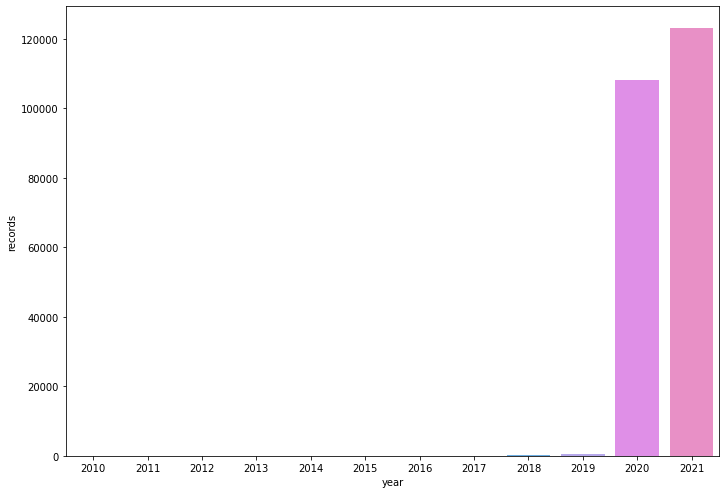

In [16]:
query = f"covid AND yearPublished>=2010 AND yearPublished<=2021"
aggregation_response = aggregations(query, aggregation_fields=["yearPublished"],entity_type="works", limit=20)
pretty_json(aggregation_response)

第四步，对数据进行可视化
- 我们将 json 文件转换为 pandas dataframe
- 然后使用 seaborn 进行可视化

In [ ]:
import seaborn as sns

year_data = aggregation_response["aggregations"]["yearPublished"]
years = pandas.DataFrame(list(year_data.items()), columns=["year", "records"]) 
years = years.sort_values("year", ascending=True)
ax = sns.barplot(x="year", y="records", data=years)

## 例子4：获取 dataproviders 的信息，并进行可视化

In [ ]:
import seaborn as sns

In [17]:
def get_dataprovider_aggregation(query, year):
    connected_ids = " OR ".join(f"dataProviders:{id}" for id in uk_data_providers.id)
    query = f"{query} AND ({connected_ids}) AND yearPublished:{year}"
    aggregation_response = aggregations(query, aggregation_fields=["dataProviders"],entity_type="works")
    dp_data = aggregation_response["aggregations"]["dataProviders"]
    dps = pandas.DataFrame(list(dp_data.items()), columns=["dp_id", "records"]) 
    dps = dps[dps.dp_id.astype(int).isin(uk_data_providers.id)]
    dps["dp_id"]=dps["dp_id"].astype(int) 
    return dps.set_index("dp_id").join(uk_data_providers.set_index("id")).reset_index().sort_values("records", ascending=False)

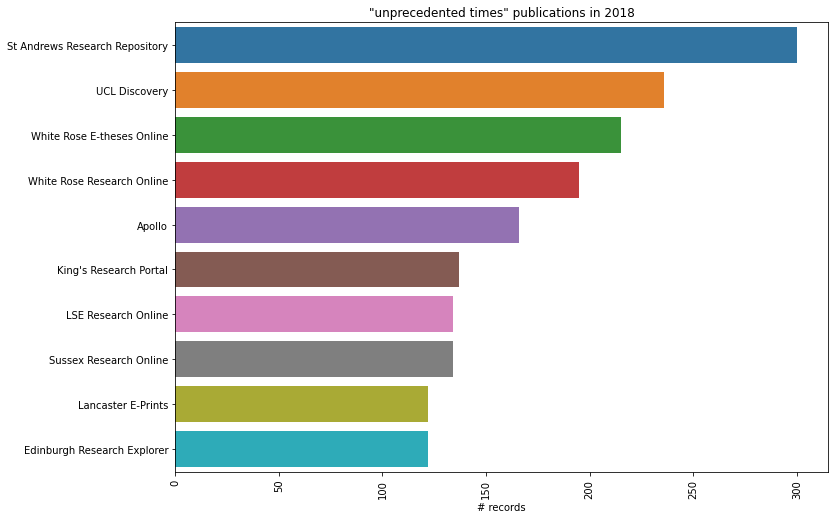

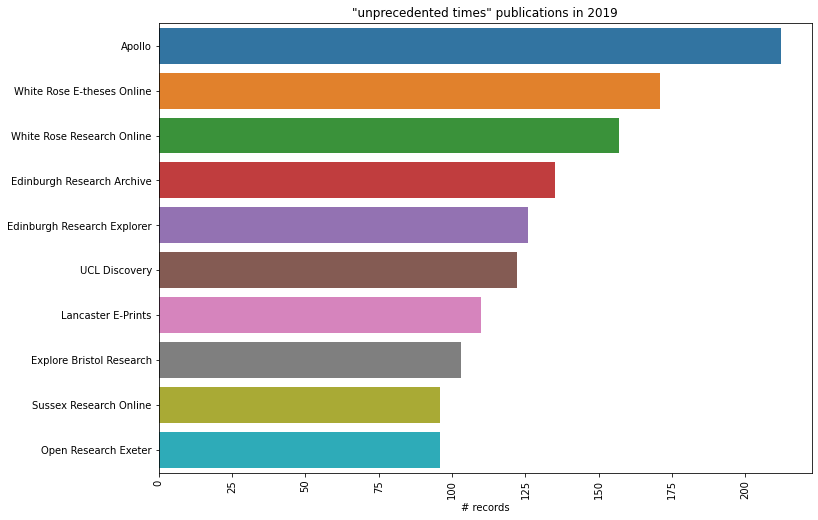

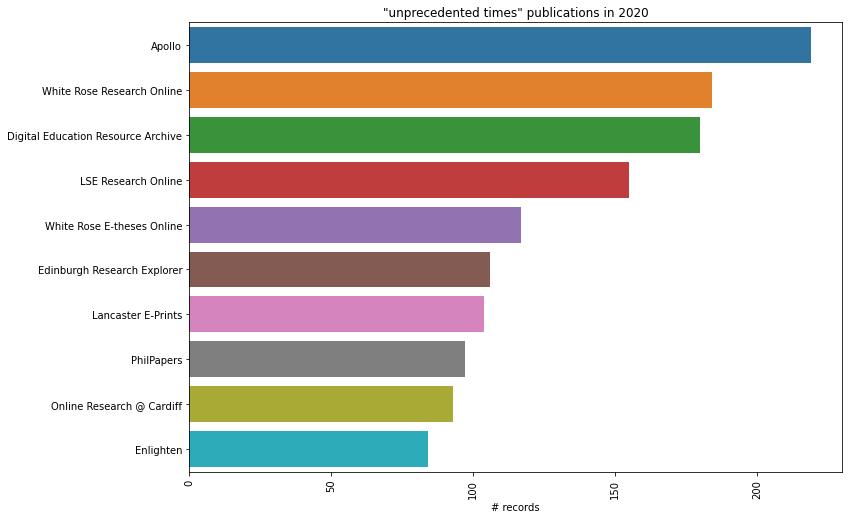

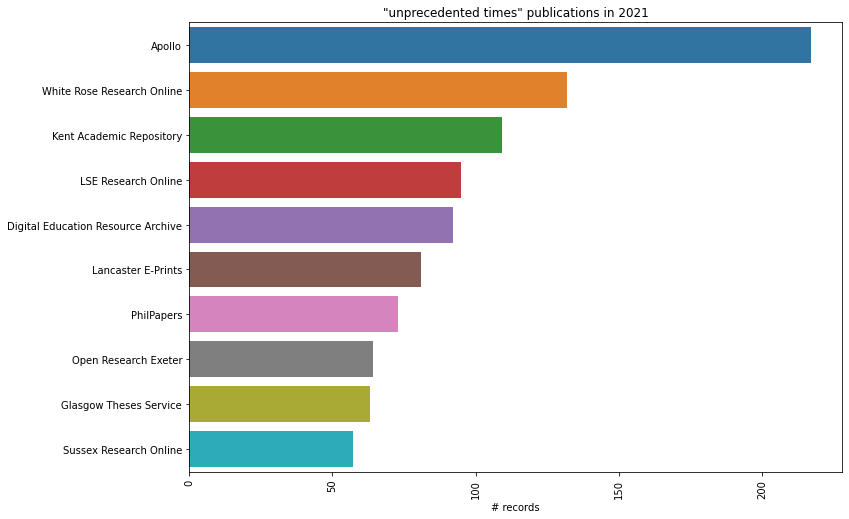

In [18]:
def plot_query(query, year, top_n=10):
    aggs = get_dataprovider_aggregation(query, year)
    ax = sns.barplot(x="records", y="name", data=aggs[:top_n])
    ax.set(xlabel="# records")
    ax.set(ylabel=None)
    plt.xticks(rotation=90)
    plt.title(f"\"{query}\" publications in {year}")
    plt.show()

plot_query("unprecedented times", 2018)
plot_query("unprecedented times", 2019)
plot_query("unprecedented times", 2020)
plot_query("unprecedented times", 2021)

## 例子5：进行网络分析和可视化

我们使用 networkx 进行网络分析和可视化

以下是定义的函数，包括使用之前的 query_api 函数进行数据检索；以及使用 networkx 的图可视化

In [19]:
import itertools
import networkx as nx

target_dps =uk_data_providers.id.to_list()
def get_repo_name(url):
    id_repo = url.split("/")[-1]
    if uk_data_providers[uk_data_providers.id==int(id_repo)].any()["name"]:
            return uk_data_providers[uk_data_providers.id==int(id_repo)]["name"].values[0]
    return "Other data providers"

def get_repo_name_if_needed(dp_url):
    id_repo = dp_url.split("/")[-1]
    if int(id_repo) in target_dps:
        dp_name=get_repo_name(id_repo)
    else: 
        dp_name="Other data providers"
    return dp_name

def get_arcs(hit):
    results = []
    if len(hit["dataProviders"])==1:
        return results
    for dpA, dpB in itertools.combinations(hit["dataProviders"],2):
        dpA_name = get_repo_name_if_needed(dpA)
        dpB_name = get_repo_name_if_needed(dpB)        
        results.append({"source":dpA_name, "target":dpB_name, "edge":"co_deposit"})
    return results

def get_collaboration_network(query, cache=True):
    filename = f"cache/{hashlib.md5(query.encode('utf-8')).hexdigest()}.csv"
    edges_df = []
    if cache:
        if os.path.exists(filename):
            edges_df = pandas.read_csv(filename)
    if len(edges_df)==0:
        covid_works = scroll("search/works", query, get_arcs)
        works= []

        for c in covid_works:
            works.extend(c)

        edges_df = pandas.DataFrame(works)
        edges_df.to_csv(filename)
        
        
    edges_df = edges_df[edges_df.target!="Other data providers"][edges_df.source!="Other data providers"].groupby(['source', "target"]).count().reset_index()

    G=nx.from_pandas_edgelist(edges_df,  "source", "target", edge_attr=True, create_using=nx.Graph())
    plt.figure(figsize=(40,40))
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    cmap = sns.color_palette("viridis", as_cmap=True)
    pos = nx.circular_layout(G)
    widths = 15 * (edges_df["edge"]/edges_df["edge"].max()) +1
    nodes = nx.draw_networkx_nodes(G, pos, node_color="indigo" )
    edges = nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=widths,
        
    )
    label_options = {"fc": "white"}
    nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)
    plt.show()
    #return edges_df.count()

In [21]:
def get_ego_network(query, cache=True):
    filename = f"cache/{hashlib.md5(query.encode('utf-8')).hexdigest()}.csv"
    edges_df = []
    if cache:
        if os.path.exists(filename):
            edges_df = pandas.read_csv(filename)
    if len(edges_df)==0:
        covid_works = scroll("search/works", query, get_arcs)
        works= []

        for c in covid_works:
            works.extend(c)

        edges_df = pandas.DataFrame(works)
        edges_df.to_csv(filename)
        
        
    edges_df = edges_df[edges_df.target!="Other data providers"][edges_df.source!="Other data providers"].groupby(['source', "target"]).count().reset_index()    
    
    
    G=nx.from_pandas_edgelist(edges_df,  "source", "target", edge_attr=True, create_using=nx.Graph())
    plt.figure(figsize=(40,40))
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    cmap = sns.color_palette("viridis", as_cmap=True)
    pos = nx.circular_layout(G)
    widths = 15 * (edges_df["edge"]/edges_df["edge"].max()) +1
    # Create a BA model graph - use seed for reproducibility
    seed = 20532

    # find node with largest degree
    node_and_degree = G.degree()
    (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

    # Create ego graph of main hub
    hub_ego = nx.ego_graph(G, largest_hub)

    # Draw graph
    pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
    nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

    # Draw ego as large and red
    options = {"node_size": 300, "node_color": "r"}
    label_options = {"fc": "white"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
    nx.draw_networkx_labels(hub_ego, pos, font_size=24, bbox=label_options)
    edges = nx.draw_networkx_edges(
        hub_ego,
        pos,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=widths,
        
    )
    plt.show()
    #return edges_df.count()

测试：检索和 covid 主题相关的 data providers，时间限定位 2021

/data/notebook/notebook-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


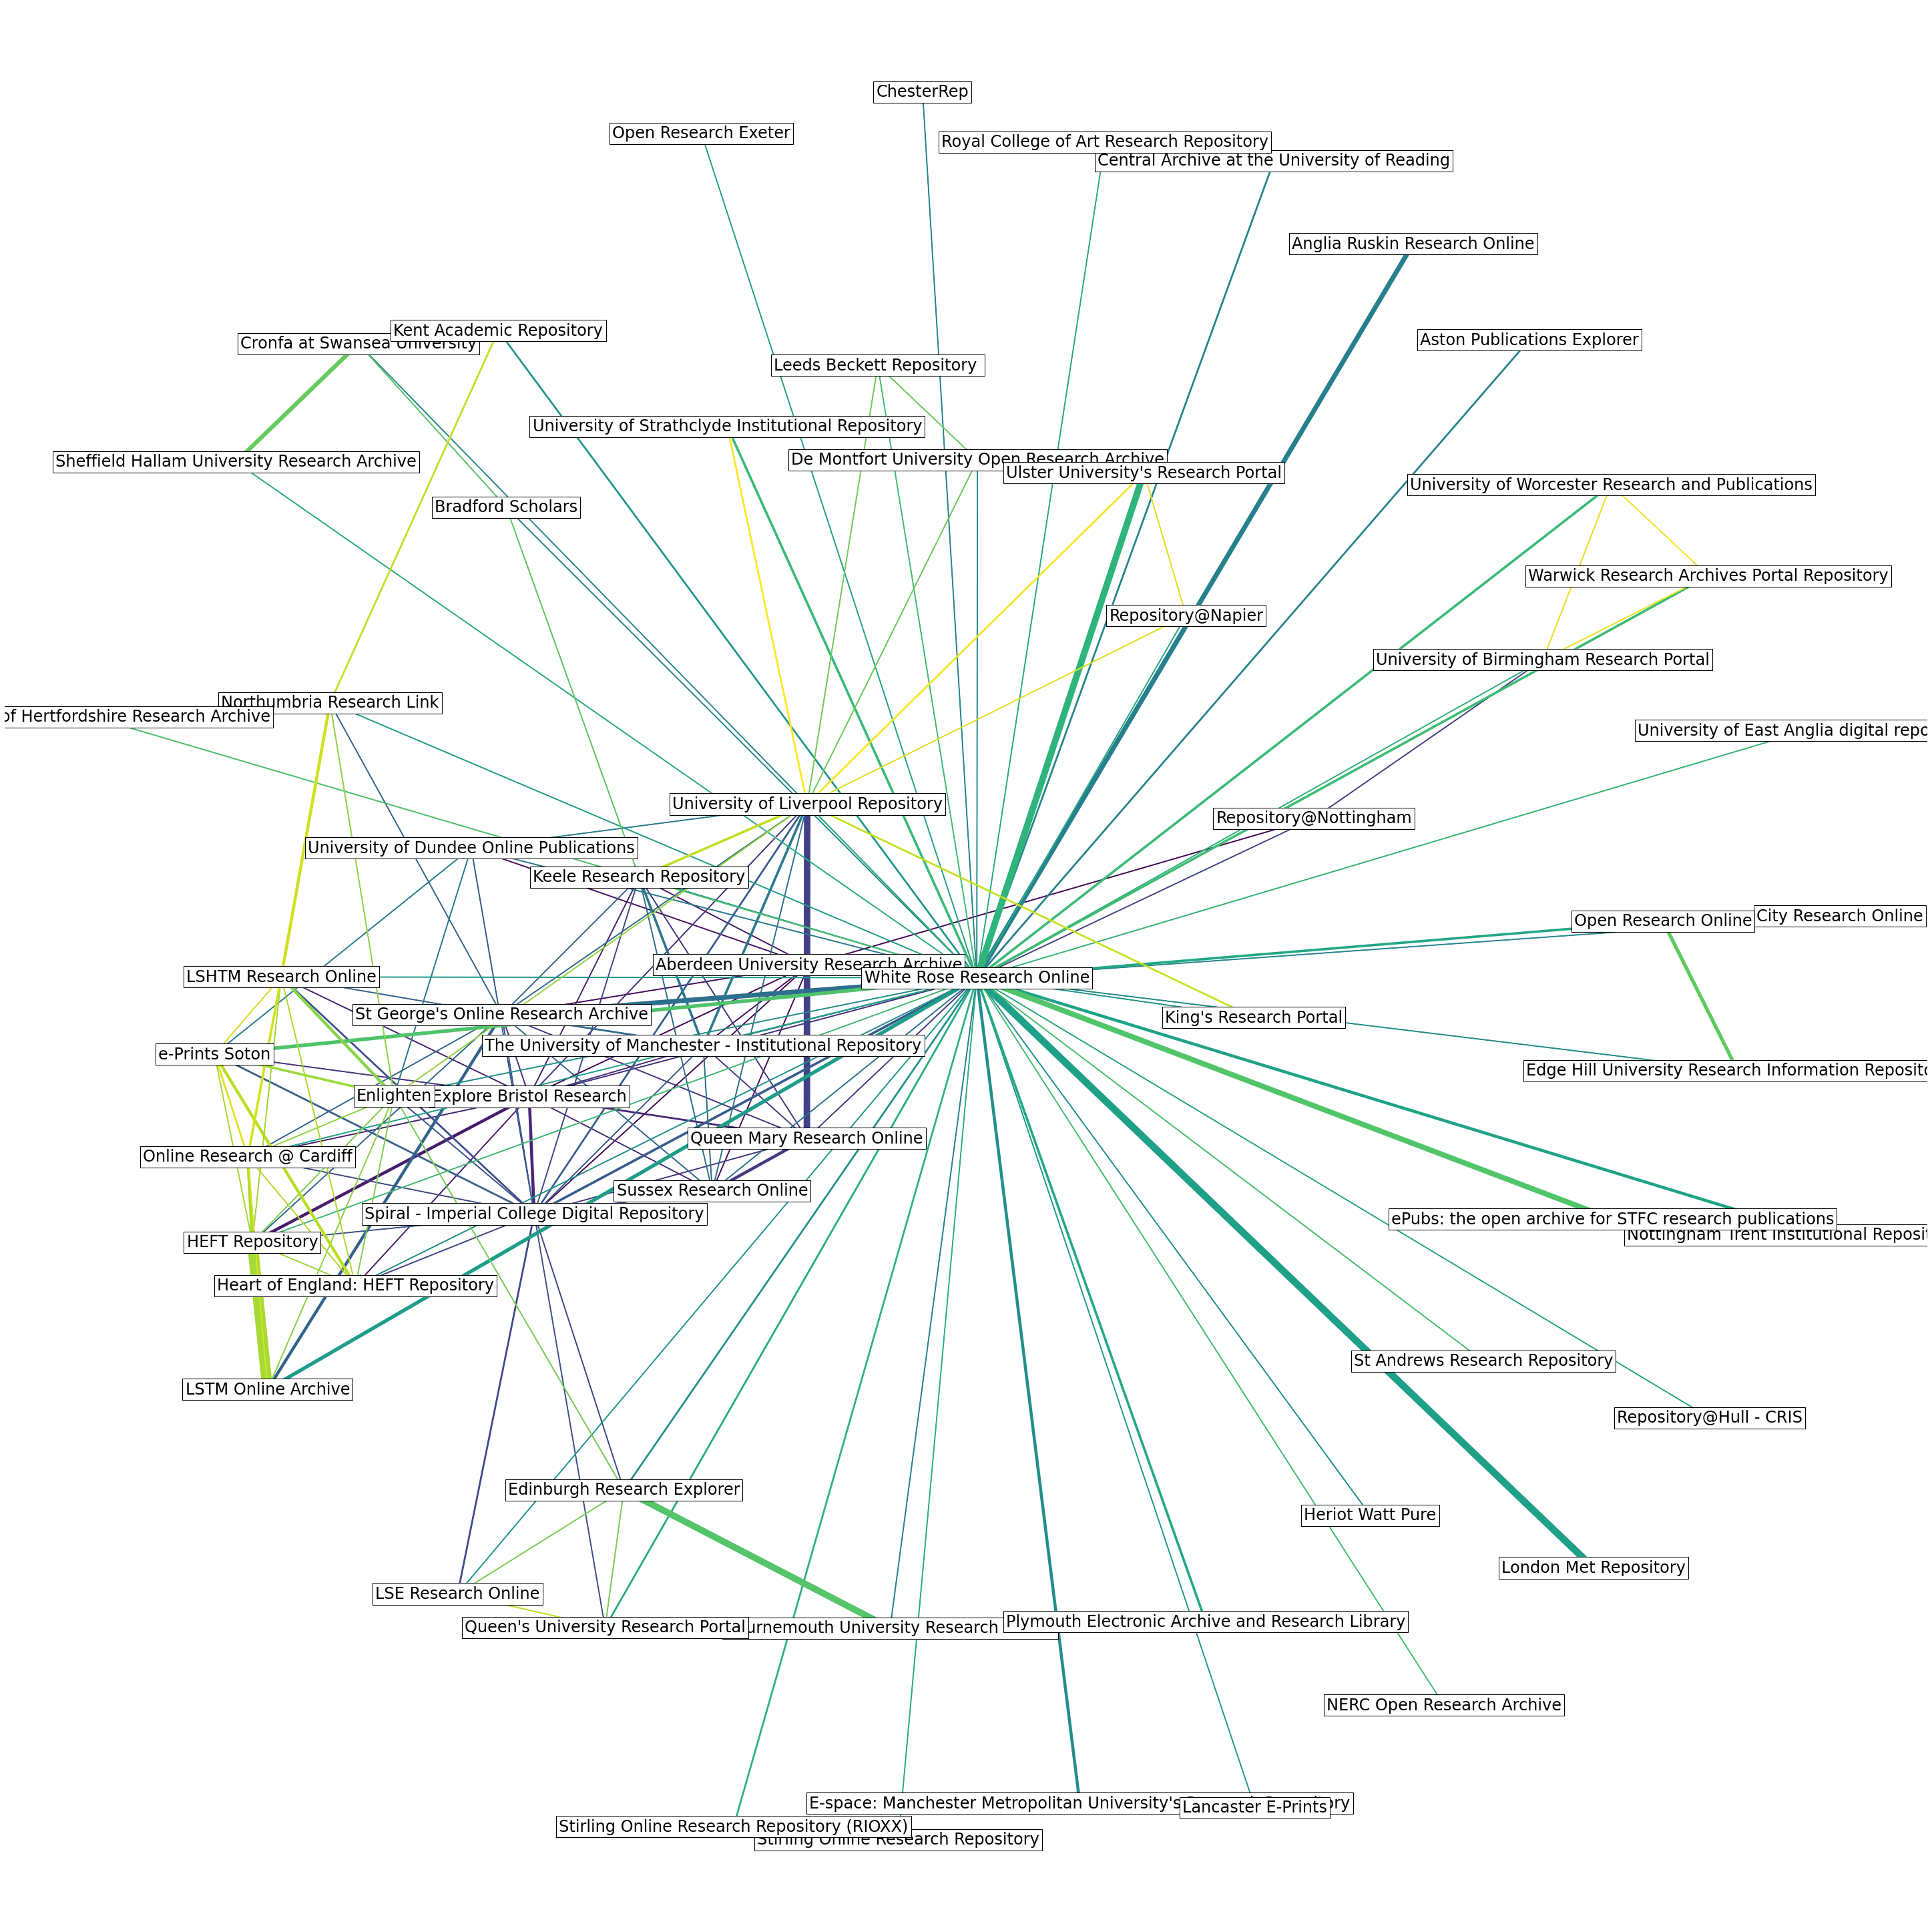

In [22]:
query = f"covid AND yearPublished:2021 AND dataProviders:140"
get_ego_network(query)

进一步扩大搜索范围：比如选择出在拉塞尔(Russel)的 data providers

/data/notebook/notebook-env/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


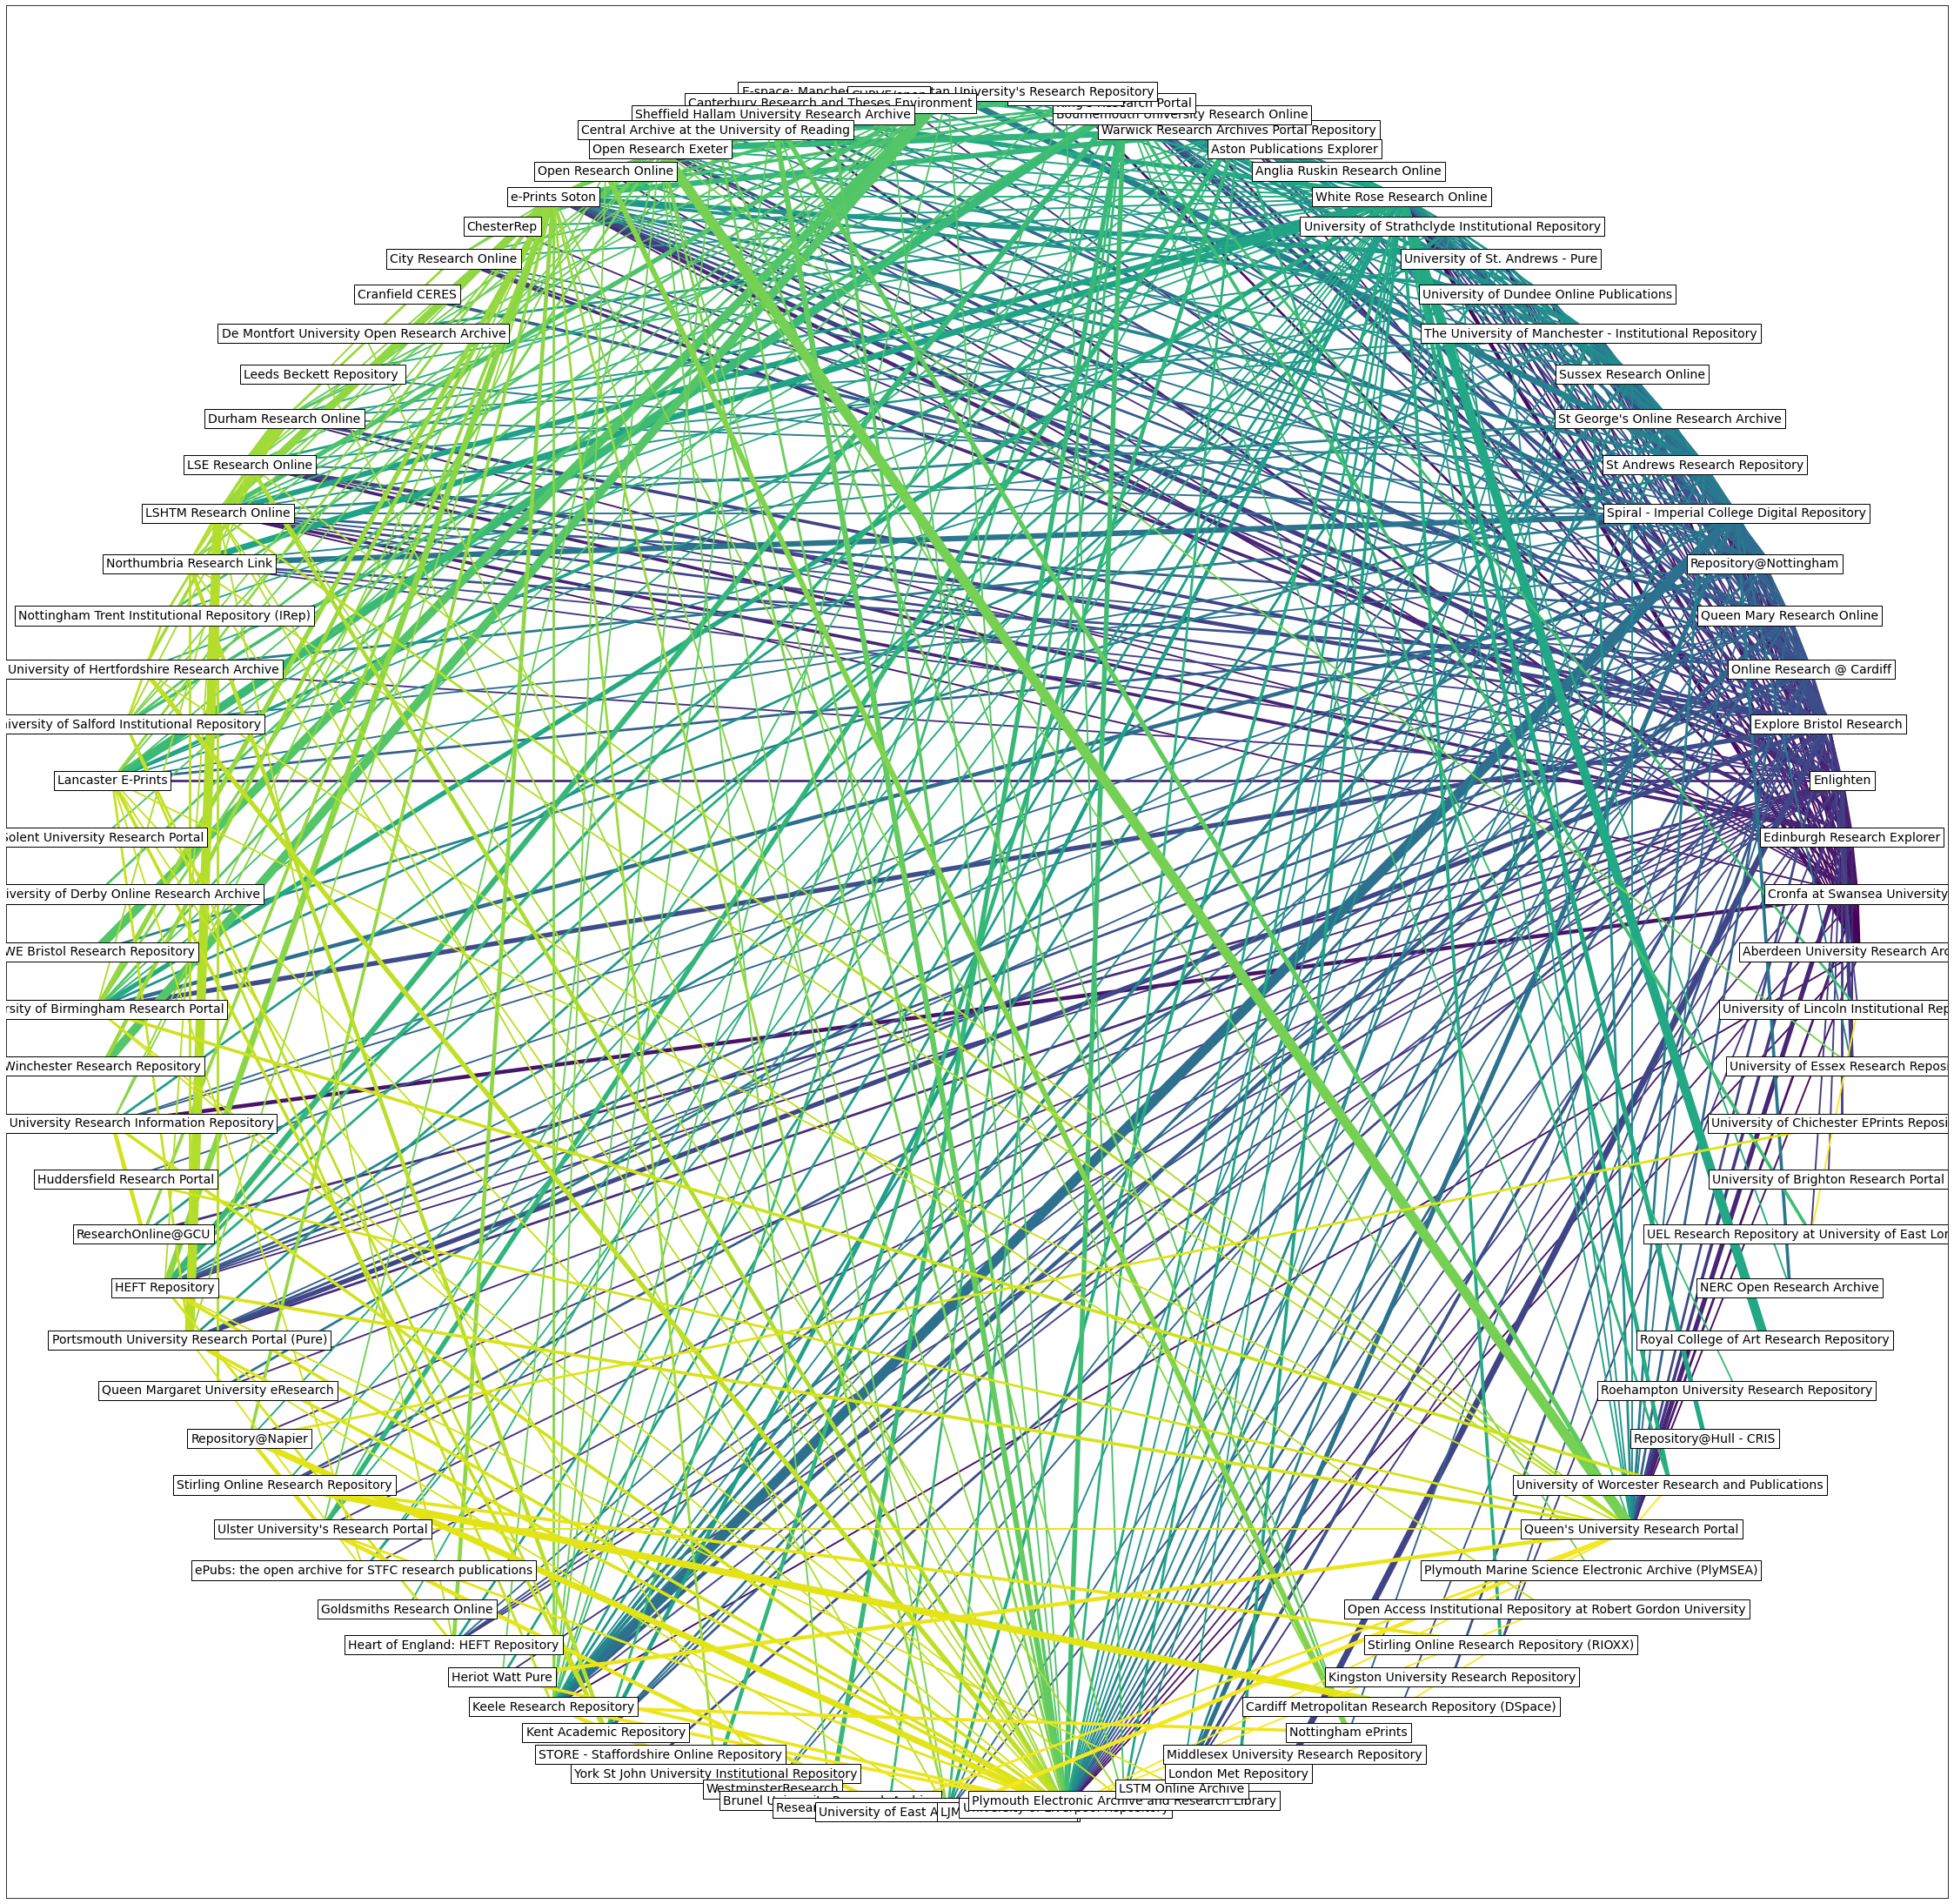

In [23]:
russel_group = [119,286,27,83,33,39,504,14443,105,635,140,129,35,252,80,88,619,289,140,36,118,136, 42, 34]
ids_to_focus = " OR ".join(f"dataProviders:{id}" for id in russel_group)
query = f"covid AND yearPublished:2021 AND ({ids_to_focus})"
get_collaboration_network(query, cache=True)

## 例子6：Dicovery API

discovery api 可以根据 doi, title, year 所搜文献的下载链接

Discovery parameters
| Field Name | Data Type |
| --- | --- |
| doi | string |
| title | string |
| year | integer |
| eprints_id | string |
| plugin_id | string |
| referrer | string |


In [53]:
def query_api(url_fragment, query):
    headers={"Authorization":"Bearer "+api_key}
    response = requests.post(f"{api_endpoint}{url_fragment}",data = json.dumps(query), headers=headers)
    if response.status_code ==200:
        return response.json(), response.elapsed.total_seconds()
    else:
        print(f"Error code {response.status_code}, {response.content}")

In [55]:
# dicovery api
query = {
  "doi": "10.1016/0370-2693(96)00910-0"
}
response = query_api("discover", query)
response

({'fullTextLink': 'http://core.ac.uk/labs/oadiscovery/redirect?url=http%3A%2F%2Farxiv.org%2Fpdf%2Fnucl-th%2F9605003&key=A6B14CDF7ABA1EFAD0C6C33EB067100B',
  'source': 'From UNPAYWALL'},
 3.584589)

## 例子7：Outputs API

Outputs API 可以
- 获取文献的各种元信息
- 获取文献的统计信息，包括发表时间等
- 下载文献的 pdf, xml等

### outputs single： 获取文献元信息

In [58]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}outputs/1"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response.json()

https://api.core.ac.uk/v3/outputs/1


{'acceptedDate': '',
 'authors': [{'name': 'Ramsden, Anne'}],
 'contributors': [],
 'createdDate': '2012-06-26T18:35:37+01:00',
 'dataProvider': {'id': 86,
  'name': 'Open Research Online',
  'url': 'https://api.core.ac.uk/v3/data-providers/86',
  'logo': 'https://api.core.ac.uk/data-providers/86/logo'},
 'depositedDate': '',
 'documentType': 'research',
 'doi': '',
 'downloadUrl': 'https://core.ac.uk/download/1.pdf',
 'fullText': 'Open Research OnlineThe Open University’s repository of research publicationsand other research outputsThe OU goes digitalJournal ItemHow to cite:Ramsden, Anne (2003). The OU goes digital. Library and Information Update, 2(2) pp. 34–35.For guidance on citations see FAQs.c© [not recorded]Version: [not recorded]Link(s) to article on publisher’s website:http://www.cilip.org.uk/publications/updatemagazine/archive/archive2003/february/update0302b.htmCopyright and Moral Rights for the articles on this site are retained by the individual authors and/or other copyri

### 下载 pdf 

In [78]:
headers={"Authorization":"Bearer "+api_key}
requests_url = f"{api_endpoint}outputs/1/download"
print(requests_url)
response = requests.get(requests_url, headers=headers)
response

https://api.core.ac.uk/v3/outputs/1/download


<Response [200]>

In [80]:
with open('outputs_api_1.pdf', 'wb') as f:
    f.write(response.content)

## CORE identifiers in Data Provider

In [ ]:
def query_api(search_url, query, scrollId=None):
    headers={"Authorization":"Bearer "+api_key}
    if not scrollId:
        response = requests.get(f"{search_url}?q={query}&limit=100&scroll=true",headers=headers)
    else:
        response = requests.get(f"{search_url}?q={query}&limit=100&scrollId={scrollId}",headers=headers)        
    return response.json(), response.elapsed.total_seconds()

def scroll(search_url, query, extract_info_callback):
    allresults = []
    count = 0
    scrollId=None
    while True:
        result, elapsed =query_api(search_url, query, scrollId)
        scrollId=result["scrollId"]
        totalhits = result["totalHits"]
        result_size = len(result["results"])
        if result_size==0:
            break
        for hit in result["results"]:
            if extract_info_callback:
              allresults.append(extract_info_callback(hit))
            else:
              allresults.append(extract_info(hit))
        count+=result_size
        print(f"{count}/{totalhits} {elapsed}s")
    return allresults
        
def extract_info(hit):
    return {"id":hit["id"], "name": hit["name"], "url":hit["oaiPmhUrl"]}

In [ ]:
headers={"Authorization":"Bearer "+api_key}

singlework = requests.get(f"https://api.core.ac.uk/v3/search/works?q=_exists_:doi&limit=1",headers=headers)
singlework.json()

In [ ]:
singlework = requests.get(f"https://api.core.ac.uk/v3/search/works?q=dataProviders:https://api.core.ac.uk/v3/data-providers/131&limit=1",headers=headers)
singlework.json()

In [ ]:
def get_ids(hit):
  return {
      "id":hit["id"],
      "arxivId":hit["arxivId"],
      "doi":hit["doi"],
      "oaiIds":",".join(hit["oaiIds"]),
      "magId":hit["magId"],
      "coreIds":",".join(hit["outputs"]),
      "pubmedId":hit["pubmedId"]
  }
response= scroll("https://api.core.ac.uk/v3/search/works", "dataProviders:https://api.core.ac.uk/v3/data-providers/14", get_ids)

In [ ]:
response